In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import geopandas as gpd
from shapely.geometry import Point, Polygon

# At first we mount the dataset from local file

inputdf = pd.read_csv('Crime.csv')

In [ ]:


# sneak peak in the data
inputdf.head(2)


In [ ]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns
inputdf.dtypes

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [ ]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

# Later, Columns related with the effect of crime are removed.

In [ ]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Now we have to visualize the data and fix what to predict from these modified feature set

In [ ]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


In [ ]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()

In [ ]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()

In [ ]:
# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

In [ ]:
inputdf['Crime Name2'].value_counts()

# Export Pandas DataFrame to CSV


In [ ]:

# inputdf.to_csv('potential feature set revised.csv')


# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [ ]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

In [ ]:
geo_df.plot()

# Visualizing the Crime Data

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
# plt.savefig('Crime Heat Map for Location')

In [ ]:
#geo_df['Crime Name1'].hist()
geo_df['Crime Name2'].count()
geo_df['Crime Name2'].value_counts()
# geo_df.groupby('Crime Name2').count() # per group data count


#geo_df['Latitude'].hist()

# Separating Train and Test Set for Crime Prediction for Location

In [ ]:
print(inputdf['Crime Name1'].value_counts())

# Creating The Location Based Crime Data Frame

In [892]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()
# print(loc_crime_df.shape)
# loc_crime_df.dtypes


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,21,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,8,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,3,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,3,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,16,7


In [893]:
# Taking only Top n classes in a column
target_column = 'Crime Name1'
top_n = 4
top_classes = {}
top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
# print(top_classes)
str_array = []
temp_df = pd.DataFrame()
for x in top_classes.keys():
    str_array.append(x)
    rows = loc_crime_df[loc_crime_df[target_column] == str (x) ]
    # print(rows)
    temp_df = temp_df.append(rows)
# print(str_array)
# temp_df


In [894]:
# print(temp_df)

In [895]:
print(temp_df[target_column].value_counts())
loc_crime_df = temp_df
print(loc_crime_df[target_column].value_counts())

Crime Against Property    140262
Crime Against Society      66848
Other                      62981
Crime Against Person       30221
Name: Crime Name1, dtype: int64
Crime Against Property    140262
Crime Against Society      66848
Other                      62981
Crime Against Person       30221
Name: Crime Name1, dtype: int64


In [896]:
 # Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]



In [897]:
 # Removing Rows on Count condition 
 # Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)
loc_crime_df.head()
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)


# Dropping null values in Zip code

In [898]:
loc_crime_df['Zip Code'].value_counts()
# loc_crime_df['dateHour'].value_counts()

20910.0    20976
20902.0    17516
20904.0    14307
20906.0    14274
20874.0    13815
           ...  
6.0            1
20990.0        1
20863.0        1
2904.0         1
20988.0        1
Name: Zip Code, Length: 148, dtype: int64

In [899]:
loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
print(loc_crime_df.shape)

(225453, 12)


In [900]:
# loc_crime_df['Crime Name2'].count()
# loc_crime_df['Crime Name2'].value_counts()

# Transform the data by label encoding

In [901]:
encoded_dict ={}
temp_df_2 = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    print(loc_crime_df[y])
    if str(y) == target_column:
        temp_df_2[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df_2[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']
#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()

0         Crime Against Property
4         Crime Against Property
10        Crime Against Property
13        Crime Against Property
17        Crime Against Property
                   ...          
312185      Crime Against Person
312210      Crime Against Person
312243      Crime Against Person
312283      Crime Against Person
312285      Crime Against Person
Name: Crime Name1, Length: 225453, dtype: object
0         1
4         1
10        1
13        1
17        1
         ..
312185    0
312210    0
312243    0
312283    0
312285    0
Name: Crime Name1, Length: 225453, dtype: int32
0                                Robbery
4                            Shoplifting
10        Burglary/Breaking and Entering
13                           Shoplifting
17                           Shoplifting
                       ...              
312185                    Simple Assault
312210                    Simple Assault
312243                    Simple Assault
312283                    Simple Assaul

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,1,34,8,34,20902.0,90,2701,39.036270,-77.049900,21,21,12
4,1,36,2,19,20876.0,75,2576,39.198295,-77.244900,17,16,7
10,1,4,0,5,20816.0,76,4126,38.965620,-77.139000,3,21,8
13,1,36,0,5,20817.0,80,1916,39.022077,-77.147376,16,7,2
17,1,36,5,32,20850.0,75,3403,39.092059,-77.153305,18,10,9


In [902]:
# print(loc_crime_df['Crime Name1'].value_counts())
# print(temp_df['Crime Name1'].value_counts())

In [903]:
#Divide the dataset into independent and dependent variables
# X = loc_crime_df.drop([target_column],axis=1)
# y = loc_crime_df[target_column]

# X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column']


# Going for generic prediction
X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
y = loc_crime_df[target_column]

print(X)


        Police District Name  City  Zip Code  Place  Street Name  dateHour  \
0                          8    34   20902.0     90         2701        21   
4                          2    19   20876.0     75         2576        17   
10                         0     5   20816.0     76         4126         3   
13                         0     5   20817.0     80         1916        16   
17                         5    32   20850.0     75         3403        18   
...                      ...   ...       ...    ...          ...       ...   
312185                     2    12   20871.0     58         2207        13   
312210                     2    19   20876.0     27         4848         1   
312243                     3    17   20879.0     92         6163        16   
312283                     6    34   20904.0     58         1210        12   
312285                     5    32   20852.0     71         5640        13   

        day  month  
0        21     12  
4        16      7  


In [904]:
print(y.value_counts())

1    138559
2     56619
0     29791
3       484
Name: Crime Name1, dtype: int64


In [905]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (180362, 8)
X_test shape: (45091, 8)
y_train shape: (180362,)
y_test shape: (45091,)


In [906]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# We will build all six models and compare their accuracy scores.



In [907]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [908]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)
    

Naïve Bayes Classifier is running
Train Score: 0.6645856612546414
Test Score: 0.6646780954070657


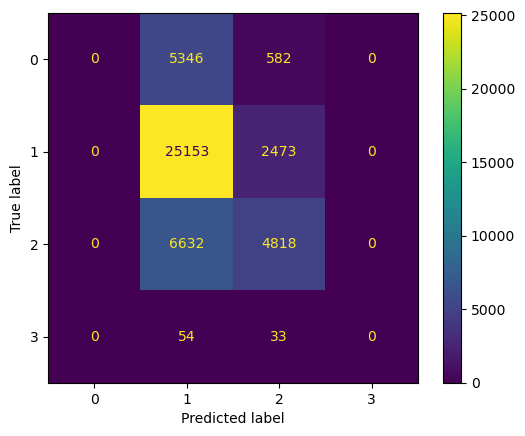

Decision Tree Classifier is running
Train Score: 0.667812528993827
Test Score: 0.6733050941429554


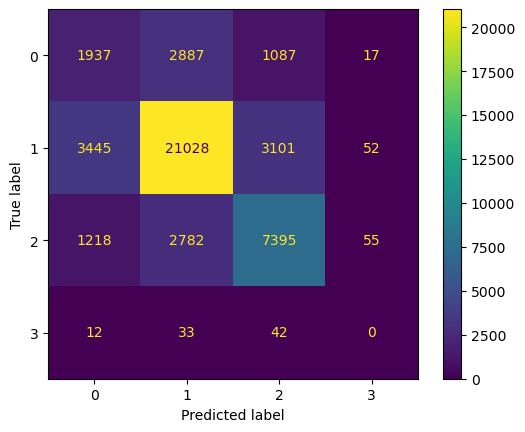

KNN Classifier is running
Train Score: 0.665467216692265
Test Score: 0.6690248608369741


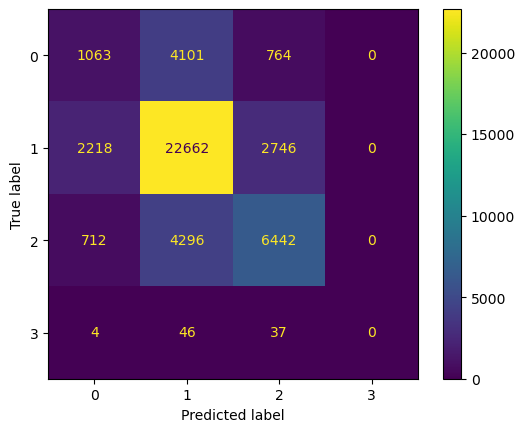

Random Forest Classifier is running
Train Score: 0.7526363689024493
Test Score: 0.7554057350690825


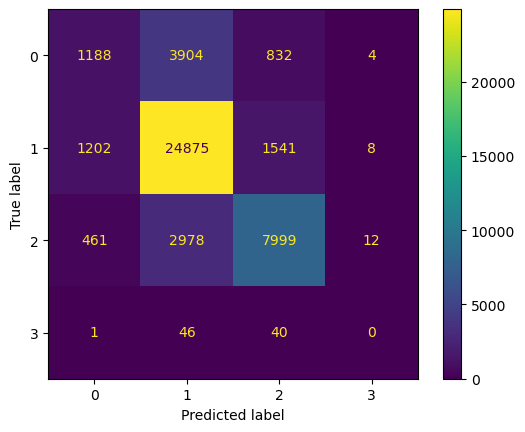

Logistic Regression is running
Train Score: 0.664430422183567
Test Score: 0.6622164068217604


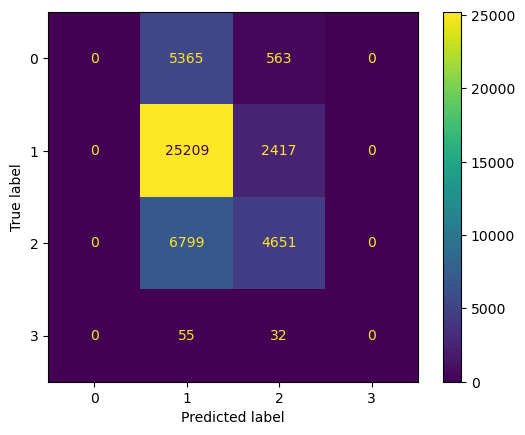

In [909]:
for model_name, model_function in models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))
    print("Test Score (F1):",f1_score(y_test, y_pred, average='micro'))
    print("Test Score (F1):",f1_score(y_test, y_pred, average='macro'))
    print("Test Score (F1):",f1_score(y_test, y_pred, average='weighted'))

    #Confusion matrix
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()


    #Store results in the dictionaries
    result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)
    


In [910]:
# lengthy_models = {'Support Vector Classifier': SVC,
#         'Random Forest Classifier': RandomForestClassifier}
# for model_name, model_function in lengthy_models.items():
#     print(model_name +' is running')
#     try:
#         model = model_function(random_state = 42)
#     except:
#         model = model_function()
#     accuracies = cross_val_score(model, X_train, y_train, cv=5)
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)

#     #Obtain accuracy
#     print("Train Score:",np.mean(accuracies))
#     print("Test Score:",model.score(X_test,y_test))


#     # #Store results in the dictionaries
#     # result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
#     # result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)

# Compare Accuracy Scores

In [911]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


                                             Score
Train Score for Naïve Bayes Classifier    0.664586
Train Score for Decision Tree Classifier  0.667813
Train Score for KNN Classifier            0.665467
Train Score for Random Forest Classifier  0.752636
Train Score for Logistic Regression       0.664430


,Score
Test Score for Naïve Bayes Classifier,0.664678
Test Score for Decision Tree Classifier,0.673305
Test Score for KNN Classifier,0.669025
Test Score for Random Forest Classifier,0.755406
Test Score for Logistic Regression,0.662216


# Display the accuracy scores

[Text(0, 0, 'Test Score for Naïve Bayes Classifier'),
 Text(1, 0, 'Test Score for Decision Tree Classifier'),
 Text(2, 0, 'Test Score for KNN Classifier'),
 Text(3, 0, 'Test Score for Random Forest Classifier'),
 Text(4, 0, 'Test Score for Logistic Regression')]

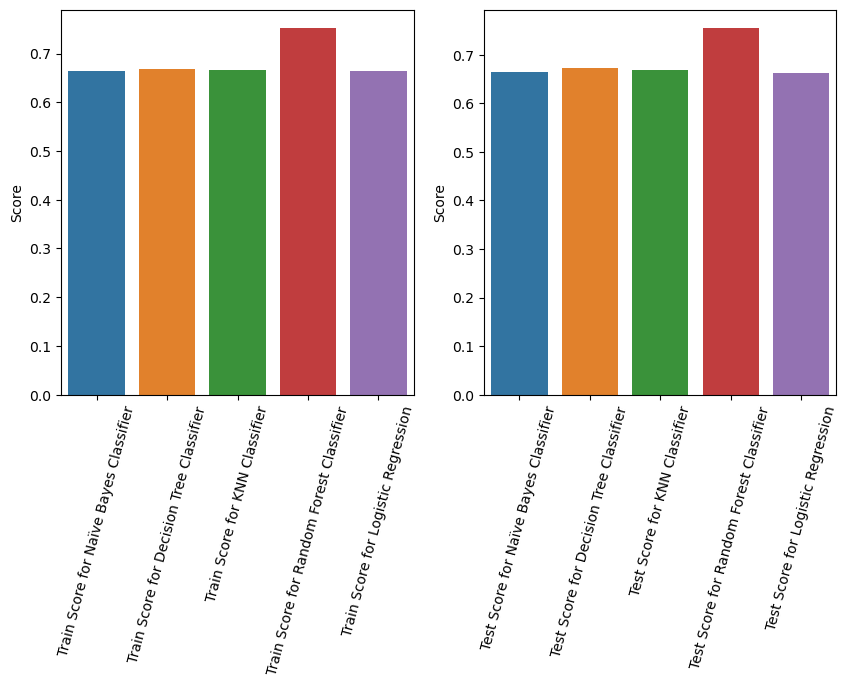

In [912]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
#plt.show()
# plt.savefig('Predicting Specific Crime With Location')